# 1. Define imports and function

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geostatspy.GSLIB as GSLIB          # GSLIB utilities, viz and wrapped functions
import geostatspy.geostats as geostats    # GSLIB converted to Python
import seaborn as sns
import scipy                              # statistics
import scipy.linalg                       # linear algebra library
import math                               # trig, etc.
import random                             # bootstrap
from scipy import stats
from scipy.stats import ttest_ind as welch     # Welch's t-test for the mean

sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
%matplotlib inline

Let's import some functions that in 06/27/2019 have not yet been incorporated to the geostats package from [Michael Pyrcz's](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Spatial_Bootstrap.ipynb) github

In [3]:
from numba import jit # for numerical speed up

@jit(nopython=True)
def cova2(x1, y1, x2, y2, nst, c0, pmx, cc, aa, it, ang, anis, rotmat, maxcov):
    """Calculate the covariance associated with a variogram model specified by a
    nugget effect and nested variogram structures.
    :param x1: x coordinate of first point
    :param y1: y coordinate of first point
    :param x2: x coordinate of second point
    :param y2: y coordinate of second point
    :param nst: number of nested structures (maximum of 4)
    :param c0: isotropic nugget constant (TODO: not used)
    :param pmx: TODO
    :param cc: multiplicative factor of each nested structure
    :param aa: parameter `a` of each nested structure
    :param it: TODO
    :param ang: TODO: not used
    :param anis: TODO
    :param rotmat: rotation matrices
    :param maxcov: TODO
    :return: TODO
    """
    EPSLON = 0.000001

    # Check for very small distance
    dx = x2 - x1
    dy = y2 - y1

    if (dx * dx + dy * dy) < EPSLON:
        cova2_ = maxcov
        return cova2_

    # Non-zero distance, loop over all the structures
    cova2_ = 0.0
    for js in range(0, nst):
        # Compute the appropriate structural distance
        dx1 = dx * rotmat[0, js] + dy * rotmat[1, js]
        dy1 = (dx * rotmat[2, js] + dy * rotmat[3, js]) / anis[js]
        h = math.sqrt(max((dx1 * dx1 + dy1 * dy1), 0.0))
        if it[js] == 1:
            # Spherical model
            hr = h / aa[js]
            if hr < 1.0:
                cova2_ = cova2_ + cc[js] * (1.0 - hr * (1.5 - 0.5 * hr * hr))
        elif it[js] == 2:
            # Exponential model
            cova2_ = cova2_ + cc[js] * np.exp(-3.0 * h / aa[js])
        elif it[js] == 3:
            # Gaussian model
            hh = -3.0 * (h * h) / (aa[js] * aa[js])
            cova2_ = cova2_ + cc[js] * np.exp(hh)
        elif it[js] == 4:
            # Power model
            cov1 = pmx - cc[js] * (h ** aa[js])
            cova2_ = cova2_ + cov1
    return cova2_

@jit(nopython=True)
def setup_rotmat(c0, nst, it, cc, ang, pmx):
    """Setup rotation matrix.
    :param c0: nugget constant (isotropic)
    :param nst: number of nested structures (max. 4)
    :param it: TODO
    :param cc: multiplicative factor of each nested structure
    :param ang: TODO
    :param pmx: TODO
    :return: TODO
    """
    PI = 3.141_592_65
    DTOR = PI / 180.0

    # The first time around, re-initialize the cosine matrix for the variogram
    # structures
    rotmat = np.zeros((4, nst))
    maxcov = c0
    for js in range(0, nst):
        azmuth = (90.0 - ang[js]) * DTOR
        rotmat[0, js] = math.cos(azmuth)
        rotmat[1, js] = math.sin(azmuth)
        rotmat[2, js] = -1 * math.sin(azmuth)
        rotmat[3, js] = math.cos(azmuth)
        if it[js] == 4:
            maxcov = maxcov + pmx
        else:
            maxcov = maxcov + cc[js]
    return rotmat, maxcov

def n_effective(df,xcol,ycol,seed,nreal,vario):
    """Calculate the number of effective data from spatial locations and spatial continuity model
    Used in bootstrap to account for spatial continuity, use n effective instead of number of data
    :param df: source DataFrame
    :param xcol: column with the X locations
    :param ycol: column with the Y locations
    :param seed: random number seed for the random sampling
    :param nreal: number of realizations to sample the variance of the average 
    :param vario: variogram model as a dictionary, see the GeostatsPy Package's GSLIB.make_variogram() function 
    :return: n_eff as effective number of data
    """ 

# Set constants
    np.random.seed(seed)
    PMX = 9999.9
    
# load the variogram
    nst = vario['nst']
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst)
    ang = np.zeros(nst); anis = np.zeros(nst)
    c0 = vario['nug']; 
    cc[0] = vario['cc1']; it[0] = vario['it1']; ang[0] = vario['azi1']; 
    aa[0] = vario['hmaj1']; anis[0] = vario['hmin1']/vario['hmaj1'];
    if nst == 2:                                   # include 2nd structure if present (optional)
        cc[1] = vario['cc2']; it[1] = vario['it2']; ang[1] = vario['azi2']; 
        aa[1] = vario['hmaj2']; anis[1] = vario['hmin2']/vario['hmaj2'];
    
# Set up the rotation matrix
    rotmat, maxcov = setup_rotmat(c0,nst,it,cc,ang,PMX)
    
# Load the data
    nd = len(df)
    x = df[xcol].values
    y = df[ycol].values
    
# Calculate Symmetric Covariance Array - assuming variogram with spherical structure with range specified
    cov = np.zeros((nd,nd))
    var_range = 100.0
    for i in range(0, nd):
        x1 = x[i]; y1 = y[i]
        for j in range(0, nd):
            x2 = x[j]; y2 = y[j]
            cova = cova2(x1, y1, x2, y2, nst, c0, PMX, cc, aa, it, ang, anis, rotmat, maxcov)
            cov[i,j] = cova
            
# Lower and upper deconvolution            
    P, L, U = scipy.linalg.lu(cov) 
    
# Build realization and calculate the average    
    average_array = np.zeros(nreal)
    rand = np.zeros((nd)) 
    for l in range(0, nreal):
        rand = np.random.normal(loc = 0.0, scale = 1.0, size = nd)
        realization = np.matmul(L,rand)
        average_array[l] = np.average(realization)
        
# Back out the number of effecitve data useing the standard error in the average
    var_average = np.var(average_array)
    n_eff = max(min(1.0/var_average, nd),1.0)    # filter n effective less than 1.0 or greater than number of data
    
    return n_eff

def n_effective2(xx, yy,seed,nreal,vario):
    """Calculate the number of effective data from spatial locations and spatial continuity model
    Used in bootstrap to account for spatial continuity, use n effective instead of number of data
    :param xx: column with the X locations
    :param yy: column with the Y locations
    :param seed: random number seed for the random sampling
    :param nreal: number of realizations to sample the variance of the average 
    :param vario: variogram model as a dictionary, see the GeostatsPy Package's GSLIB.make_variogram() function 
    :return: n_eff as effective number of data
    """ 

# Set constants
    np.random.seed(seed)
    PMX = 9999.9
    
# load the variogram
    nst = vario['nst']
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst)
    ang = np.zeros(nst); anis = np.zeros(nst)
    c0 = vario['nug']; 
    cc[0] = vario['cc1']; it[0] = vario['it1']; ang[0] = vario['azi1']; 
    aa[0] = vario['hmaj1']; anis[0] = vario['hmin1']/vario['hmaj1'];
    if nst == 2:                                   # include 2nd structure if present (optional)
        cc[1] = vario['cc2']; it[1] = vario['it2']; ang[1] = vario['azi2']; 
        aa[1] = vario['hmaj2']; anis[1] = vario['hmin2']/vario['hmaj2'];
    
# Set up the rotation matrix
    rotmat, maxcov = setup_rotmat(c0,nst,it,cc,ang,PMX)
    
# Load the data
    nd = xx.size
    x = np.ndarray.flatten(xx)
    y = np.ndarray.flatten(yy)
    
# Calculate Symmetric Covariance Array - assuming variogram with spherical structure with range specified
    cov = np.zeros((nd,nd))
    var_range = 100.0
    for i in range(0, nd):
        x1 = x[i]; y1 = y[i]
        for j in range(0, nd):
            x2 = x[j]; y2 = y[j]
            cova = cova2(x1, y1, x2, y2, nst, c0, PMX, cc, aa, it, ang, anis, rotmat, maxcov)
            cov[i,j] = cova
            
# Lower and upper deconvolution            
    P, L, U = scipy.linalg.lu(cov) 
    
# Build realization and calculate the average    
    average_array = np.zeros(nreal)
    rand = np.zeros((nd)) 
    for l in range(0, nreal):
        rand = np.random.normal(loc = 0.0, scale = 1.0, size = nd)
        realization = np.matmul(L,rand)
        average_array[l] = np.average(realization)
        
# Back out the number of effecitve data useing the standard error in the average
    var_average = np.var(average_array)
    n_eff = max(min(1.0/var_average, nd),1.0)    # filter n effective less than 1.0 or greater than number of data
    
    return n_eff

In [4]:
def moving_window(array, xo, yo, distance_x, distance_y, vert_horz, steps):
    """
    ONLY WORK WITH setps=1
    moving_window computes a fixed windows that either moves horizontally or vertically and
    samples values from the array.
    
    Variables:
    array: 2D array
    xo, yo : coordinate points of the left edge corner of  window
    distance_x : longitude of window in the x direction
    distance_y : longitude of window in the y direction
    vert_horz : 1 if window has to move vertically (horizontally fixed); 0 if window should move horizontally
    steps = number of steps or movements you want the window to perform
    
    Returns:
    2D array where the columns have all the selected points. Columns have length (distance_x * distance_y)
    """
    rows, cols = array.shape # computes the number of rows and columns of the array
    rows -= 1; cols -= 1
    y_index = []; x_index = []
    ###### Indexes of array ######
    x = np.arange(0, 999, 10)
    xx, yy = np.meshgrid(x, x)
    
    ###### Window moving vertically ######
    if vert_horz == 1: # window moving vertically
        a = []
        max_ver_dist = rows - yo + 1 # maximum vertical distance of window
        max_hor_dist = cols - xo + 1 # maximum horizontal distance of window
        
        if distance_y > max_ver_dist: # you have surpassed the maximum vertical distance
            distance_y = max_ver_dist
            print('Maximum vertical distance has been updated to = {0:.0f}'.format(max_ver_dist))
        elif distance_x > max_hor_dist: # you have surpassed the maximum horizontal distance
            distance_x = max_hor_dist
            print('Maximum horizontal distance has been updated to = {0:.0f}'.format(max_hor_dist))
        
        max_num_steps = rows - (distance_y  + yo - 2) # maximum number of steps allowed with that vertical size
        
        if steps > max_num_steps: # update the maximum number of steps allowed
            steps = max_num_steps
            print('Steps have been updated to = {0:.0f}'.format(max_num_steps))
            
        temp = array[yo:yo + distance_y + steps - 1, xo:xo + distance_x] # slice the original array containing all steps
        temp_yy = yy[yo:yo + distance_y + steps - 1, xo:xo + distance_x]
        
        rows, cols = temp.shape
        
        for i in range(0, rows - distance_y + 1): # to move down vertically sampling all rows
            window = temp[i:i + distance_y, :].reshape((-1,1)) # each individual window
            window_y = temp_yy[i:i + distance_y, :].reshape((-1,1)) # saving the indexes
            a.append(window) # store the sampled values in a list
            y_index.append(window_y) # store the y indexes in a list
            
        sampling = np.hstack(a) # convert the above list to an array
        yy = np.hstack(y_index) # convert y indexes list to an array      
        xx = np.hstack(list(xx[0, xo:xo + distance_x]) * distance_y) # the indexes in x are fixed
        result = pd.DataFrame(sampling.reshape(-1, 1), columns=['Porosity'])
        result['X'] = xx.reshape(-1, 1)
        result['Y'] = yy.reshape(-1, 1)

    ###### Window moving horizontally ######
    elif vert_horz == 0: # window moving vertically
        a = []
        max_ver_dist = rows - yo + 1 # maximum vertical distance of window
        max_hor_dist = cols - xo + 1 # maximum horizontal distance of window
        
        if distance_y > max_ver_dist: # you have surpassed the maximum vertical distance
            distance_y = max_ver_dist
            print('Maximum vertical distance has been updated to = {0:.0f}'.format(max_ver_dist))
        elif distance_x > max_hor_dist: # you have surpassed the maximum horizontal distance
            distance_x = max_hor_dist
            print('Maximum horizontal distance has been updated to = {0:.0f}'.format(max_hor_dist))
        
        max_num_steps = cols - (distance_x + xo - 2) # maximum number of steps allowed with that horizontal size
        if steps > max_num_steps: # update the maximum number of steps allowed
            steps = max_num_steps
            print('Steps have been updated to = {0:.0f}'.format(max_num_steps))
            
        temp = array[yo:yo + distance_y, xo:xo + distance_x + steps - 1] # slice the original array
        temp_xx = xx[yo:yo + distance_y, xo:xo + distance_x + steps - 1]
        
        rows, cols = temp.shape
        
        for i in range(0, steps): # to move down vertically sampling all rows ###rows - distance_y + 1
            window = temp[:, i:i + distance_x].reshape((-1,1)) # each individual window
            window_x = temp_xx[:, i:i + distance_x].reshape((-1,1)) # saving the indexes
            a.append(window) # store the sampled values in a list
            x_index.append(window_x) # store the y indexes in a list
            
        sampling = np.hstack(a) # convert the above list to an array
        xx = np.hstack(x_index) # convert y indexes list to an array      
        yy = np.hstack(list(yy[yo:yo + distance_y, 0]) * distance_x) # the indexes in x are fixed
        result = pd.DataFrame(sampling.reshape(-1, 1), columns=['Porosity'])
        result['X'] = xx.reshape(-1, 1)
        result['Y'] = yy.reshape(-1, 1)
        
    else:
        print('Please select the correct variables.')
    
    return result

It is useful to see how much a block of code takes to run. Let's use the homemade version of Matlab tic and toc functions (Modified from [Stackoverflow](http://stackoverflow.com/questions/5849800/tic-toc-functions-analog-in-python))

In [92]:
def tic():
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        time_a = time.time() - startTime_for_tictoc
        days = round(time_a // 86400)   # Total days
        residual1 = (time_a / 86400) - days # seconds left for hours computations
        hours = round(residual1 * 86400) // 3600 # I use round because of machine precision issues
        residual2 = round(residual1 * 86400) - hours *3600 # seconds left for minute computations
        minutes = residual2 // 60 # Total minutes
        seconds = residual2 - minutes * 60 # Total seconds
        if days == 1:
            print('Elapsed time: ' + str(days) + ' day '+ str(hours) + ' hours ' + str(minutes)
              + ' minutes ' + str(seconds) + ' seconds.')
        else:
            print('Elapsed time: ' + str(days) + ' days '+ str(hours) + ' hours ' + str(minutes)
              + ' minutes ' + str(seconds) + ' seconds.')
    else:
        print("Toc: start time not set")

In [5]:
def moving_window(array, df, xo, yo, distance_x, distance_y, vert_horz, steps):
    """
    moving_window computes a fixed windows that either moves horizontally or vertically and
    samples values from the array.
    
    Variables:
    array: 2D array
    df: DataFrame that has the coordinates X and Y
    xo, yo : coordinate points of the left edge corner of  window
    distance_x : longitude of window in the x direction
    distance_y : longitude of window in the y direction
    vert_horz : 1 if window has to move vertically (horizontally fixed); 0 if window should move horizontally
    steps = number of steps or movements you want the window to perform
    
    Returns:
    2D array where the columns have all the selected points. Columns have length (distance_x * distance_y)
    """
    rows, cols = array.shape # computes the number of rows and columns of the array
    rows -= 1; cols -= 1
    x_ind = []; y_ind = [] # list of indexes in x and y
    
    if vert_horz == 1: # window moving vertically
        a = []
        max_ver_dist = rows - yo + 1 # maximum vertical distance of window
        max_hor_dist = cols - xo + 1 # maximum horizontal distance of window
        
        if distance_y > max_ver_dist: # you have surpassed the maximum vertical distance
            distance_y = max_ver_dist
            print('Maximum vertical distance has been updated to = {0:.0f}'.format(max_ver_dist))
        elif distance_x > max_hor_dist: # you have surpassed the maximum horizontal distance
            distance_x = max_hor_dist
            print('Maximum horizontal distance has been updated to = {0:.0f}'.format(max_hor_dist))
        
        max_num_steps = rows - (distance_y  + yo - 2) # maximum number of steps allowed with that vertical size
        
        if steps > max_num_steps: # update the maximum number of steps allowed
            steps = max_num_steps
            print('Steps have been updated to = {0:.0f}'.format(max_num_steps))
            
        temp = array[yo:yo + distance_y + steps - 1, xo:xo + distance_x] # slice the original array
        
        rows, cols = temp.shape
        
        for i in range(0, rows - distance_y + 1): # to move down vertically sampling all rows
            window = temp[i:i + distance_y, :].reshape((-1,1)) # each individual window
            a.append(window) # store the sampled values in a list
#             y_ind.append(yo+i:)
            
        result = np.hstack(a) # convert the above list to an array
        
    elif vert_horz == 0: # window moving vertically
        a = []
        max_ver_dist = rows - yo + 1 # maximum vertical distance of window
        max_hor_dist = cols - xo + 1 # maximum horizontal distance of window
        
        if distance_y > max_ver_dist: # you have surpassed the maximum vertical distance
            distance_y = max_ver_dist
            print('Maximum vertical distance has been updated to = {0:.0f}'.format(max_ver_dist))
        elif distance_x > max_hor_dist: # you have surpassed the maximum horizontal distance
            distance_x = max_hor_dist
            print('Maximum horizontal distance has been updated to = {0:.0f}'.format(max_hor_dist))
        
        max_num_steps = cols - (distance_x + xo - 2) # maximum number of steps allowed with that horizontal size
        if steps > max_num_steps: # update the maximum number of steps allowed
            steps = max_num_steps
            print('Steps have been updated to = {0:.0f}'.format(max_num_steps))
            
        temp = array[yo:yo + distance_y, xo:xo + distance_x + steps - 1] # slice the original array
        
        rows, cols = temp.shape
        
        for i in range(0, steps): # to move down vertically sampling all rows ###rows - distance_y + 1
            window = temp[:, i:i + distance_x].reshape((-1,1)) # each individual window
            a.append(window) # store the sampled values in a list
            
        result = np.hstack(a) # convert the above list to an array
        
    else:
        print('Please select the correct variables.')
    
    return result

In [ ]:
## using N2 effective, fixed arrays
tic()
# x = np.arange(0, 999, 10)
# xx, yy = np.meshgrid(x, x)

# N1_X = xx[:30, 50:80]; N1_Y = yy[:30, 50:80]
# N2_X = xx[70:, :30]; N2_Y = yy[70:, :30]

num_sim = 11 # number of simulations

# create the DataFrame that will store all results
summary = pd.DataFrame(np.zeros((num_sim, 10)), columns=['N1 Mean', 'N2 Mean', 'Diff Means','N1 neff', 
                                                        'N2 neff', 'N eff', 'Naive t', 'Naive pvalue',
                                                        'Eff t', 'Eff pvalue'])

means_diff = np.zeros((num_sim, 1))
n_eff = np.zeros_like(means_diff)

for simulation in range(0, num_sim):
    sim = GSLIB.sgsim_uncond(1, nx, ny, cell_size, seed+simulation, vario, 'simulation')
    sim = GSLIB.affine(array=sim, tmean=15, tstdev=1.5) # correct the distribution to a target mean and standard deviation
    
    ############################################################
    ## Compute the means of the data sampling sets
    ############################################################
    mean1 = np.mean(sim[:30, 50:80]); mean2 = np.mean(sim[70:, :30])
    summary.iloc[simulation, 0] = mean1
    summary.iloc[simulation, 1] = mean2
    
    ############################################################
    ## Compute n effective of both data sampling sets
    ############################################################
    n1 = n_effective2(N1_X, N1_Y, seed=seed+simulation, nreal=1000, vario=vario)
    n2 = n_effective2(N2_X, N2_Y, seed=seed+simulation, nreal=1000, vario=vario)
    summary.iloc[simulation, 3] = n1
    summary.iloc[simulation, 4] = n2
    
    ############################################################
    ## Welch's test using scipy
    ############################################################
    summary.iloc[simulation, 6], summary.iloc[simulation, 7] = welch(sim[:30, 50:80], sim[70:, :30],
                                                                     axis=None, equal_var=False)
    
    ############################################################
    ## Welch's test using n effective
    ############################################################
    # t statistic
    var1 = np.var(sim[:30, 50:80], ddof=1); var2 = np.var(sim[70:, :30], ddof=1)
    t = (mean1 - mean2) / np.sqrt((var1/n1) + (var2/n2))
    summary.iloc[simulation, 8] = t # saving the t statistic considering n effective
    
    # degrees of freedom
    if n1 <= 1:
        n1 = 2
        print('n1 has changed')
    elif n2 <= 2:
        n2 = 2
        print('n2 has changed')

    dof = (((var1 / n1) + (var2 / n2)) ** 2) \
            /((((var1 / n1)**2) / (n1 - 1)) + (((var2 / n2)**2) / (n2 - 1)))
    
    summary.iloc[simulation, 9] = (1 - stats.t.cdf(t, df=dof))*2 # saving the p value considering n effective
    
############################################################
## Final computations
############################################################
summary['Diff Means'] = summary['N1 Mean'] - summary['N2 Mean']
summary['N eff'] = (summary['N1 neff'] + summary['N2 neff']) / 2
summary['Eff pvalue'].values[summary['Eff pvalue'].values > 1] = 1

toc()

# 2. Variogram and unconditional simulation

We will now create (simulate) porosity data to populate an array of shape 100x100. First, we need to establish the modeling parameters.

In [27]:
# Modeling parameters, the model grid, the random seed, the target distribution, and color bar
nx = 100; ny = 100; cell_size = 10                               # grid number of cells and cell size
xmin = 0.0; ymin = 0.0                                           # grid origin
xmax = xmin + nx * cell_size; ymax = ymin + ny * cell_size       # calculate the extent of model
seed = 42                                                        # random number seed  for stochastic simulation   
range_max = 100; range_min = 10; azimuth = 30                   # Porosity variogram ranges and azimuth
mean = 15.0; stdev = 1.5                                         # Porosity mean and standard deviation
cmap = plt.cm.inferno                                            # using the plasma color map

Then, we have to define the spatial continuity of our model; i.e., define the variogram.

In [28]:
vario = GSLIB.make_variogram(nug=0, nst=1, it1=1, cc1=1.0, azi1=azimuth, hmaj1=90, hmin1=70)
# vario = GSLIB.make_variogram(nug=1, nst=1, it1=1, cc1=0.0, azi1=azimuth, hmaj1=90, hmin1=70) # pure nugget effect
# vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=azimuth,hmaj1=1000000,hmin1=1000000) # zonal anisotropy
# vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=azimuth,hmaj1=1000000,hmin1=1000000) # range of model size

Now proceed with the simulation. If you did not see it before, the simulation uses a range (90) that is less than 1/10 of the extent of the model (1000 m).

After the simulattion we use `GSLIB.affine` to change and move the shape of the distribution with the values of mean and standard deviation we want.

In [29]:
sim = GSLIB.sgsim_uncond(1, nx, ny, cell_size, seed, vario, 'simulation')

sim = GSLIB.affine(sim, mean, stdev)              # correct the distribution to a target mean and standard deviation.

Finally, we plot the simulation.

<Figure size 720x576 with 0 Axes>

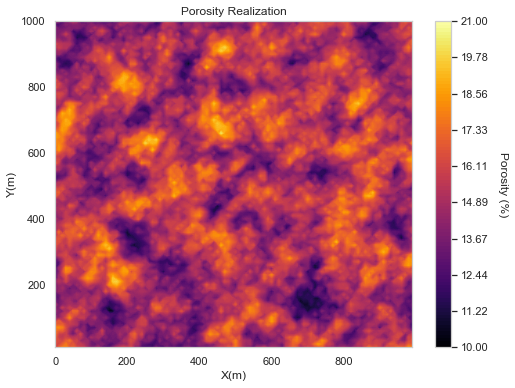

In [30]:
plt.figure(figsize=(10, 8));
                       
GSLIB.pixelplt(sim, xmin, xmax, ymin, ymax, cell_size, np.floor(np.min(sim)), np.ceil(np.max(sim)),
               "Porosity Realization", "X(m)", "Y(m)", "Porosity (%)",cmap, 'Porosity_Simulation');

Instead of having a fixed window, we will randomly sample 100 porosity samples from the field for the and N1 and N2. Therefore, we will have to get the X and Y coordinates of the simulation and the porosity values themselves into a `DataFrame`.

In [31]:
x = np.arange(0, 999, 10) # The field has 100 cells in both X and Y and extends from 0 to 990 meters
xx, yy = np.meshgrid(x, x) # create a meshgrid to simplify the addition of coordinate 

# X coordinates format
xcoor = list(x)
xcoor = np.array(xcoor * 100)

# Y coordinates format
ycoor = []
for i in np.arange(len(x)):
    ycoor += list(yy[i, :])
ycoor = np.array(ycoor)
    
# DataFrame
simulation = pd.DataFrame(np.ndarray.flatten(sim), columns=['Porosity'])
simulation['X'] = xcoor
simulation['Y'] = ycoor

N1 = simulation.sample(frac=0.01, random_state=42) # random sampling of 100 values: 10% of 10,000
N2 = simulation.sample(frac=0.01, random_state=13) # random sampling

# N1 = pd.DataFrame(sim[:30, 50:80].reshape(-1, 1), columns=['Porosity'])
# N1['X'] = xx[:30, 50:80].reshape(-1, 1)
# N1['Y'] = yy[:30, 50:80].reshape(-1, 1)

# N2 = pd.DataFrame(sim[70:, :30].reshape(-1, 1), columns=['Porosity'])
# N2['X'] = xx[70:, :30].reshape(-1, 1)
# N2['Y'] = yy[70:, :30].reshape(-1, 1)

Let's verify whether N1 and N2 are taking the same porosity samples.

In [32]:
sum(N1.index == N2.index)

0

Because the sum of the boolean array is zero, we conclude that N1 and N2 are not taking the same porosity values. Now, instead of showing the table for each N1 and N2, let's visualize the datasets in the field.

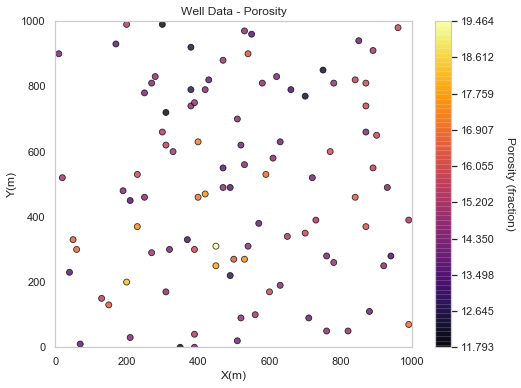

In [33]:
pormin = N1['Porosity'].min()
pormax = N1['Porosity'].max()

GSLIB.locmap(N1, 'X', 'Y', 'Porosity', xmin, xmax, ymin, ymax, pormin, pormax,
             'Well Data - Porosity', 'X(m)', 'Y(m)', 'Porosity (fraction)', cmap,'locmap_Porosity');

# Modified Welch's test

Now, here comes the fun part. We will perform 1000 simulations of the field keeping the random samples location fixed. In other words, the coordinates of N1 and N2 won't change but the simulation array will because the random seed generation will. In brief, this is what the next lines do:

* **1**. Simulate porosity values changing in each iteration the seed number
* **2**. Compute the mean of N1 and N2
* **3**. Compute n effective for both N1 and N2
* **4**. Compute the naive Welch's test
* **5**. Compute Welch's test using n effective
* **6**. Repeat the steps above 1000 times or more

More about Welch's test and p-values

* [Wikipedia](https://en.wikipedia.org/wiki/Welch%27s_t-test) offers a review of Welch's test
* [Jason Brownlee](https://machinelearningmastery.com/how-to-code-the-students-t-test-from-scratch-in-python/) explains how to code the t-test and how to [code a two-tailed test](https://machinelearningmastery.com/critical-values-for-statistical-hypothesis-testing/)
* [Tim Ojo](https://dzone.com/articles/what-is-p-value-in-layman-terms) explains the p value
* [Minitab blog](https://blog.minitab.com/blog/adventures-in-statistics-2/understanding-t-tests-t-values-and-t-distributions) explains the t-distributions a t-values

The following [test](https://www.geogebra.org/m/YRh9H3t5) will be performed with a confidence interval of 95%, i.e., $\alpha=0.05$

$\large{H_0 : \bar{x_1} = \bar{x_2}}$

$\text{vs}$

$\large{H_1 : \bar{x_1} \neq{} \bar{x_2}  }$

## N1 and N2 have the same size

In [22]:
summary = pd.read_pickle("./summary1.pkl")

In [118]:
tic()

num_sim = 1000 # number of sim_is

# create the DataFrame that will store all results
summary = pd.DataFrame(np.zeros((num_sim, 11)), columns=['N1 Mean', 'N2 Mean', 'Diff Means','N1 neff', 
                                                        'N2 neff', 'N eff', 'Naive t', 'Naive pvalue',
                                                        't_stat', 'p-value', 'Critical Value'])

means_diff = np.zeros((num_sim, 1)) # initialize the array where you will store the difference of means
n_eff = np.zeros_like(means_diff) # initialize the array where you will store the average n effective

for sim_i in range(0, num_sim):
    sim = GSLIB.sgsim_uncond(1, nx, ny, cell_size, seed+sim_i, vario, 'sim_i')
    sim = GSLIB.affine(array=sim, tmean=15, tstdev=1.5) # correct the distribution to a target mean and standard deviation
    
    ############################################################
    ## Compute the means of the data sampling sets
    ############################################################
    mean1 = np.mean(sim.ravel()[N1.index.values])
    mean2 = np.mean(sim.ravel()[N2.index.values])
    summary.iloc[sim_i, 0] = mean1
    summary.iloc[sim_i, 1] = mean2
    
    ############################################################
    ## Compute n effective of both data sampling sets
    ############################################################
    n1 = n_effective(N1, 'X', 'Y', seed=seed+sim_i, nreal=1000, vario=vario)
    n2 = n_effective(N2, 'X', 'Y', seed=seed+sim_i, nreal=1000, vario=vario)
    summary.iloc[sim_i, 3] = n1
    summary.iloc[sim_i, 4] = n2
    
    ############################################################
    ## Welch's test using scipy
    ############################################################
    # two-tailed test
    summary.iloc[sim_i, 6], summary.iloc[sim_i, 7] \
    = welch(sim.ravel()[N1.index.values], sim.ravel()[N2.index.values], axis=None, equal_var=False)
    
    ############################################################
    ## Welch's test using n effective
    ############################################################
    # t statistic
    var1 = np.var(sim.ravel()[N1.index.values], ddof=1) # ddof=1 means that we are dividing by n-1 to have an unbiased statistic
    var2 = np.var(sim.ravel()[N2.index.values], ddof=1)
    t_stat = (mean1 - mean2) / np.sqrt((var1/n1) + (var2/n2))
    summary.iloc[sim_i, 8] = t_stat # saving the t statistic considering n effective
    
    # degrees of freedom
    if n1 <= 1:
        n1 = 2
        print('n1 has changed')
    elif n2 <= 2:
        n2 = 2
        print('n2 has changed')

    dof = (((var1 / n1) + (var2 / n2)) ** 2) \
            /((((var1 / n1)**2) / (n1 - 1)) + (((var2 / n2)**2) / (n2 - 1)))
    
    # calculate the critical value
    critical_value = stats.t.ppf(1.0 - 0.05/2, dof) # percent point function (PPF) for a 5% significance level
    summary.iloc[sim_i, 10] = critical_value # store the critical value in the DataFrame
    
    # calculate the p-value
    p = (1 - stats.t.cdf(abs(t_stat), dof)) * 2 # compute the two-tail p-value 
    summary.iloc[sim_i, 9] = p # store that p-value
    
############################################################
## Final computations
############################################################
summary['Diff Means'] = summary['N1 Mean'] - summary['N2 Mean'] # compute difference of the means
summary['N eff'] = (summary['N1 neff'] + summary['N2 neff']) / 2 # average of n effectives
summary['t_stat <= cv'] = abs(summary['t_stat']) <= abs(summary['Critical Value']) # whether or not to reject Ho using t_stat
summary['p > 0.05'] = summary['p-value'] > 0.05 # whether or not to reject Ho using the p-value

toc()

Elapsed time: 0 days 0 hours 4 minutes 55 seconds.


In [119]:
summary.head()

,N1 Mean,N2 Mean,Diff Means,N1 neff,N2 neff,N eff,Naive t,Naive pvalue,t_stat,p-value,Critical Value,t_stat <= cv,p > 0.05
0,14.900341,15.065515,-0.165174,66.710313,66.563527,66.636920,-0.802973,0.422958,-0.655453,0.513329,1.978296,True,True
1,14.991023,15.168213,-0.177190,75.816621,74.635739,75.226180,-0.815110,0.415991,-0.706813,0.480795,1.976140,True,True
2,14.970870,14.939922,0.030948,73.676344,70.204026,71.940185,0.147372,0.882989,0.124896,0.900784,1.976967,True,True
3,14.980879,15.274938,-0.294059,71.313033,71.146567,71.229800,-1.520714,0.129936,-1.283505,0.201440,1.977092,True,True
4,15.072320,14.934906,0.137414,79.208659,76.517747,77.863203,0.631522,0.528436,0.557693,0.577870,1.975600,True,True


The table above evaluates whether to not reject or reject the null hypothesis with a significance level of 0.05 with two methods. It compares the t statistic with the critical value and the p value with the significance level. The `True` statement in each instance refers that you must not reject $H_0$

With a confidence interval of 95%, we should fail to reject the null hypothesis of the Welch's two-tailed modified test 95% of the time. That is, 5% of the time all test should have p values less than 0.05. For 10000 simulations, we should reject $H_0$ 500 times. Let's count how many times that happen:

In [121]:
rej_rate_cv = (len(summary) - sum(summary['t_stat <= cv'])) / len(summary)
rej_rate_pv = len(summary[summary['p > 0.05'] == False]) / len(summary)
rej_rate_naive = len(summary[summary['Naive pvalue'] < 0.05]) / len(summary)

print("Rejection rate:\n")
print("Naive Welch                        : {0:2.2%}".format(rej_rate_naive))
print("Modified Welch with critical value : {0:2.2%}".format(rej_rate_cv))
print("Naive Welch's with p-value         : {0:2.2%}".format(rej_rate_pv))

Rejection rate:

Naive Welch                        : 5.00%
Modified Welch with critical value : 2.10%
Naive Welch's with p-value         : 2.10%


Because the p-values are probabilities, they should follow an uniform distribution between 0 and 1. Let's check if that occurs:

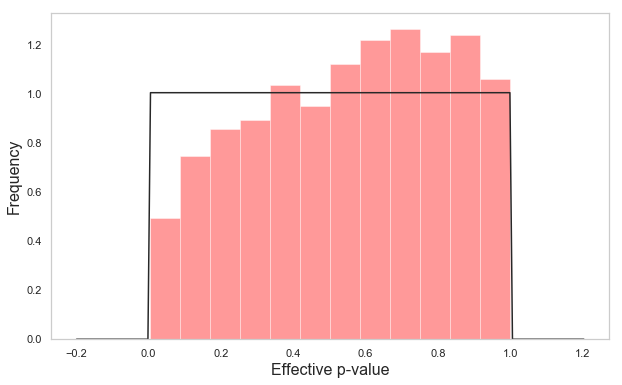

In [122]:
plt.figure(figsize=(10, 6))
sns.distplot(summary['p-value'], kde=False, fit=stats.uniform, color='red')
plt.xlabel('Effective p-value',fontsize='16')
plt.ylabel('Frequency',fontsize='16');

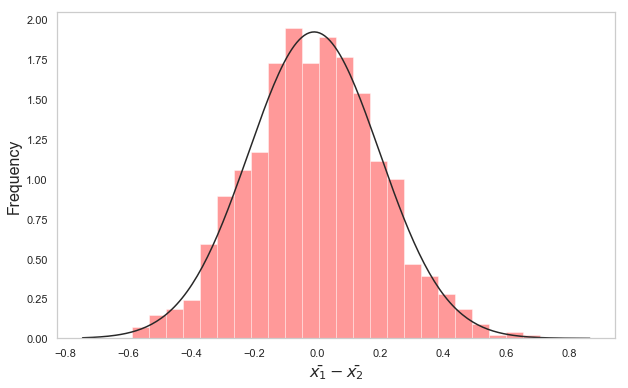

In [123]:
plt.figure(figsize=(10, 6))
sns.distplot(summary['Diff Means'], kde=False, fit=stats.t, color='red')
plt.xlabel(r'$\bar{x_1} - \bar{x_2}$',fontsize='16')
plt.ylabel('Frequency',fontsize='16');

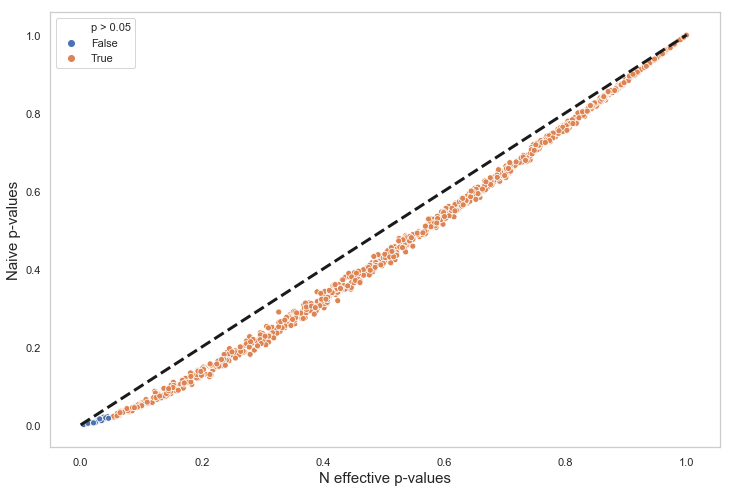

In [124]:
x = np.linspace(0, 1, 100)
plt.figure(figsize=((12, 8)))
plt.plot(x, x, 'k--', linewidth=3)
sns.scatterplot(x="p-value", y="Naive pvalue", hue="p > 0.05", data=summary)
plt.xlabel('N effective p-values', fontsize=15)
plt.ylabel('Naive p-values', fontsize=15);

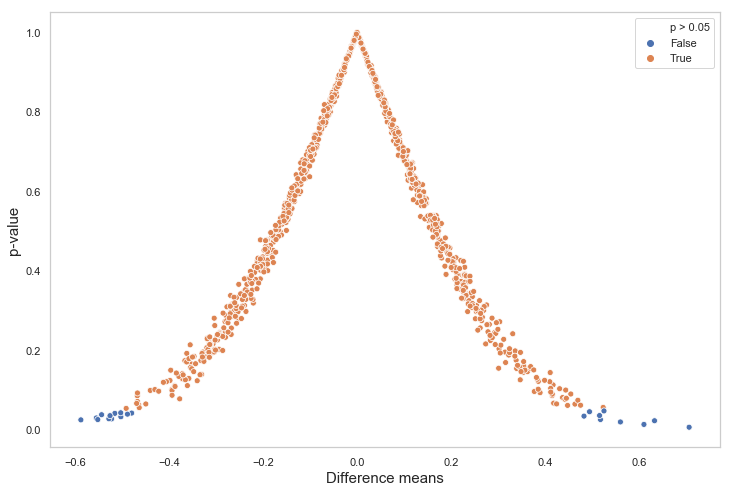

In [125]:
plt.figure(figsize=((12, 8)))
sns.scatterplot(x="Diff Means", y="p-value", hue="p > 0.05", data=summary)
plt.xlabel('Difference means', fontsize=15)
plt.ylabel('p-value', fontsize=15);

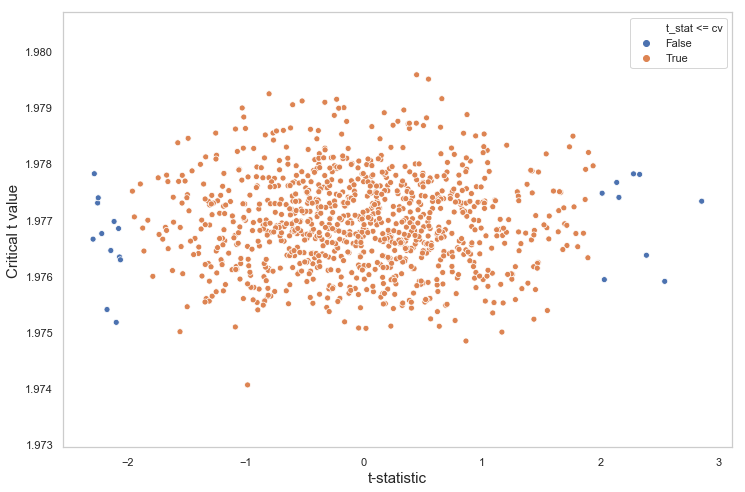

In [126]:
plt.figure(figsize=((12, 8)))
sns.scatterplot(x="t_stat", y="Critical Value", hue="t_stat <= cv", data=summary)
plt.xlabel('t-statistic', fontsize=15)
plt.ylabel('Critical t value', fontsize=15);

In [66]:
# summary.to_pickle("./summary1.pkl")

## N1 and N2 have different sizes

In [212]:
N1 = simulation.sample(frac=0.01, random_state=1960) # random sampling of 100 values: 1% of 10,000
N2 = simulation.sample(frac=0.02, random_state=1963) # random sampling

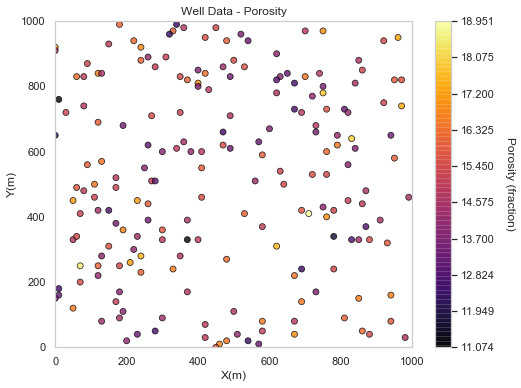

In [213]:
pormin = N2['Porosity'].min()
pormax = N2['Porosity'].max()

GSLIB.locmap(N2, 'X', 'Y', 'Porosity', xmin, xmax, ymin, ymax, pormin, pormax,
             'Well Data - Porosity', 'X(m)', 'Y(m)', 'Porosity (fraction)', cmap,'locmap_Porosity');

In [39]:
summary = pd.read_pickle("./summary2.pkl")

In [124]:
tic()

num_sim = 10000 # number of sim_is

# create the DataFrame that will store all results
summary = pd.DataFrame(np.zeros((num_sim, 11)), columns=['N1 Mean', 'N2 Mean', 'Diff Means','N1 neff', 
                                                        'N2 neff', 'N eff', 'Naive t', 'Naive pvalue',
                                                        't_stat', 'p-value', 'Critical Value'])

means_diff = np.zeros((num_sim, 1)) # initialize the array where you will store the difference of means
n_eff = np.zeros_like(means_diff) # initialize the array where you will store the average n effective

# for sim_i in range(0, num_sim):
    sim = GSLIB.sgsim_uncond(1, nx, ny, cell_size, seed+sim_i, vario, 'sim_i')
    sim = GSLIB.affine(array=sim, tmean=15, tstdev=1.5) # correct the distribution to a target mean and standard deviation
    
    ############################################################
    ## Compute the means of the data sampling sets
    ############################################################
    mean1 = np.mean(sim.ravel()[N1.index.values])
    mean2 = np.mean(sim.ravel()[N2.index.values])
    summary.iloc[sim_i, 0] = mean1
    summary.iloc[sim_i, 1] = mean2
    
    ############################################################
    ## Compute n effective of both data sampling sets
    ############################################################
    n1 = n_effective(N1, 'X', 'Y', seed=seed+sim_i, nreal=1000, vario=vario)
    n2 = n_effective(N2, 'X', 'Y', seed=seed+sim_i, nreal=1000, vario=vario)
    summary.iloc[sim_i, 3] = n1
    summary.iloc[sim_i, 4] = n2
    
    ############################################################
    ## Welch's test using scipy
    ############################################################
    # two-tailed test
    summary.iloc[sim_i, 6], summary.iloc[sim_i, 7] \
    = welch(sim.ravel()[N1.index.values], sim.ravel()[N2.index.values], axis=None, equal_var=False)
    
    ############################################################
    ## Welch's test using n effective
    ############################################################
    # t statistic
    var1 = np.var(sim.ravel()[N1.index.values], ddof=1) # ddof=1 means that we are dividing by n-1 to have an unbiased statistic
    var2 = np.var(sim.ravel()[N2.index.values], ddof=1)
    t_stat = (mean1 - mean2) / np.sqrt((var1/n1) + (var2/n2))
    summary.iloc[sim_i, 8] = t_stat # saving the t statistic considering n effective
    
    # degrees of freedom
    if n1 <= 1:
        n1 = 2
        print('n1 has changed')
    elif n2 <= 2:
        n2 = 2
        print('n2 has changed')

    dof = (((var1 / n1) + (var2 / n2)) ** 2) \
            /((((var1 / n1)**2) / (n1 - 1)) + (((var2 / n2)**2) / (n2 - 1)))
    
    # calculate the critical value
    critical_value = stats.t.ppf(1.0 - 0.05/2, dof) # percent point function (PPF) for a 5% significance level
    summary.iloc[sim_i, 10] = critical_value # store the critical value in the DataFrame
    
    # calculate the p-value
    p = (1 - stats.t.cdf(abs(t_stat), dof)) * 2 # compute the two-tail p-value 
    summary.iloc[sim_i, 9] = p # store that p-value
    
############################################################
## Final computations
############################################################
summary['Diff Means'] = summary['N1 Mean'] - summary['N2 Mean'] # compute difference of the means
summary['N eff'] = (summary['N1 neff'] + summary['N2 neff']) / 2 # average of n effectives
summary['t_stat <= cv'] = abs(summary['t_stat']) <= summary['Critical Value'] # whether or not to reject Ho using t_stat
summary['p > 0.05'] = summary['p-value'] > 0.05 # whether or not to reject Ho using the p-value

toc()

Time elapsed:1 hour 8 minutes 3 seconds.


In [127]:
summary.describe()

,N1 Mean,N2 Mean,Diff Means,N1 neff,N2 neff,N eff,Naive t,Naive pvalue,t_stat,p-value,Critical Value
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,15.001021,15.000098,0.000923,65.498652,108.659738,87.079195,0.005370,0.500721,0.004178,0.578668,1.656195
std,0.152805,0.103152,0.181595,2.978950,4.837638,3.343235,0.992363,0.286807,0.776572,0.260955,0.000962
min,14.413491,14.613038,-0.615326,54.078573,91.970607,76.446605,-3.325628,0.000288,-2.582692,0.004811,1.653395
25%,14.898485,14.930028,-0.123377,63.408177,105.339727,84.771197,-0.670963,0.256234,-0.525343,0.375354,1.655503
50%,15.000664,15.000787,0.002580,65.390522,108.512746,87.008271,0.014274,0.498145,0.011163,0.596753,1.656137
75%,15.103259,15.068984,0.125612,67.461251,111.809641,89.265668,0.686566,0.748698,0.537715,0.802991,1.656820
max,15.635462,15.382486,0.641939,78.785544,126.861811,100.984193,3.680610,0.999960,2.859871,0.999969,1.660538


In [40]:
len(summary) - sum(summary['t_stat <= cv']) # n effective

317

In [41]:
# Using the p-value with a significance level of 5%
len(summary[summary['p > 0.05'] == False])

108

In [42]:
summary['Naive pvalue'][summary['Naive pvalue'] < 0.05].count() # naive Welch

461

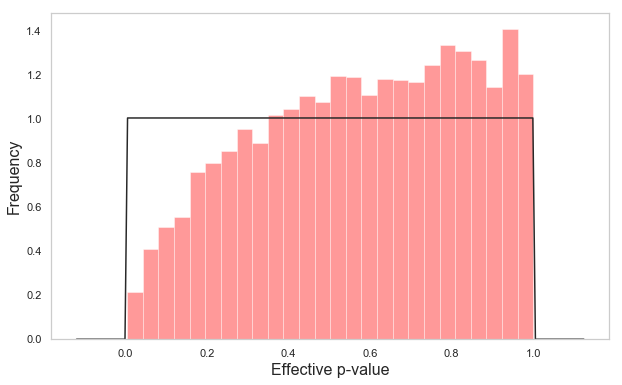

In [43]:
plt.figure(figsize=(10, 6))
sns.distplot(summary['p-value'], kde=False, fit=stats.uniform, color='red')
plt.xlabel('Effective p-value',fontsize='16')
plt.ylabel('Frequency',fontsize='16');

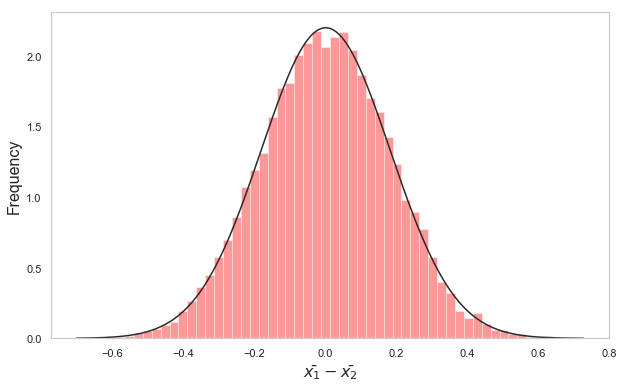

In [44]:
plt.figure(figsize=(10, 6))
sns.distplot(summary['Diff Means'], kde=False, fit=stats.t, color='red')
plt.xlabel(r'$\bar{x_1} - \bar{x_2}$',fontsize='16')
plt.ylabel('Frequency',fontsize='16');

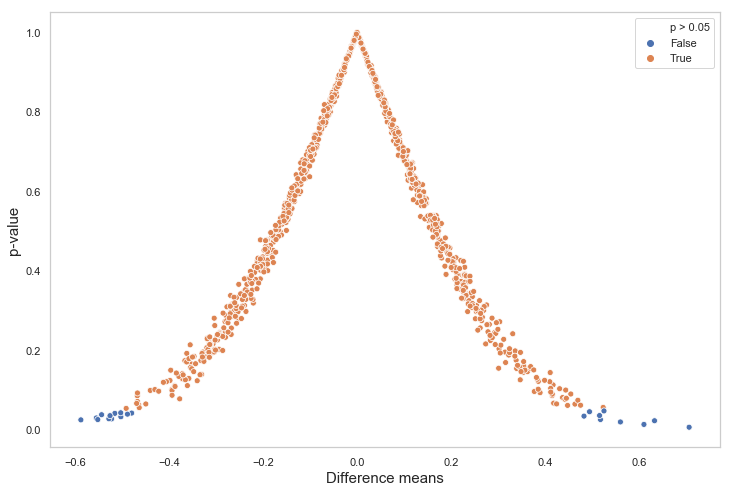

In [72]:
plt.figure(figsize=((12, 8)))
sns.scatterplot(x="Diff Means", y="p-value", hue="p > 0.05", data=summary)
plt.xlabel('Difference means', fontsize=15)
plt.ylabel('p-value', fontsize=15);

In [132]:
# summary.to_pickle("./summary2.pkl")

## N1 and N2 have smaller sample size

In [45]:
N1 = simulation.sample(frac=0.005, random_state=1960) # random sampling of 100 values: 1% of 10,000
N2 = simulation.sample(frac=0.005, random_state=1963) # random sampling

In [46]:
tic()

num_sim = 10000 # number of sim_is

# create the DataFrame that will store all results
summary = pd.DataFrame(np.zeros((num_sim, 11)), columns=['N1 Mean', 'N2 Mean', 'Diff Means','N1 neff', 
                                                        'N2 neff', 'N eff', 'Naive t', 'Naive pvalue',
                                                        't_stat', 'p-value', 'Critical Value'])

means_diff = np.zeros((num_sim, 1)) # initialize the array where you will store the difference of means
n_eff = np.zeros_like(means_diff) # initialize the array where you will store the average n effective

for sim_i in range(0, num_sim):
    sim = GSLIB.sgsim_uncond(1, nx, ny, cell_size, seed+sim_i, vario, 'sim_i')
    sim = GSLIB.affine(array=sim, tmean=15, tstdev=1.5) # correct the distribution to a target mean and standard deviation
    
    ############################################################
    ## Compute the means of the data sampling sets
    ############################################################
    mean1 = np.mean(sim.ravel()[N1.index.values])
    mean2 = np.mean(sim.ravel()[N2.index.values])
    summary.iloc[sim_i, 0] = mean1
    summary.iloc[sim_i, 1] = mean2
    
    ############################################################
    ## Compute n effective of both data sampling sets
    ############################################################
    n1 = n_effective(N1, 'X', 'Y', seed=seed+sim_i, nreal=1000, vario=vario)
    n2 = n_effective(N2, 'X', 'Y', seed=seed+sim_i, nreal=1000, vario=vario)
    summary.iloc[sim_i, 3] = n1
    summary.iloc[sim_i, 4] = n2
    
    ############################################################
    ## Welch's test using scipy
    ############################################################
    # two-tailed test
    summary.iloc[sim_i, 6], summary.iloc[sim_i, 7] \
    = welch(sim.ravel()[N1.index.values], sim.ravel()[N2.index.values], axis=None, equal_var=False)
    
    ############################################################
    ## Welch's test using n effective
    ############################################################
    # t statistic
    var1 = np.var(sim.ravel()[N1.index.values], ddof=1) # ddof=1 means that we are dividing by n-1 to have an unbiased statistic
    var2 = np.var(sim.ravel()[N2.index.values], ddof=1)
    t_stat = (mean1 - mean2) / np.sqrt((var1/n1) + (var2/n2))
    summary.iloc[sim_i, 8] = t_stat # saving the t statistic considering n effective
    
    # degrees of freedom
    if n1 <= 1:
        n1 = 2
        print('n1 has changed')
    elif n2 <= 2:
        n2 = 2
        print('n2 has changed')

    dof = (((var1 / n1) + (var2 / n2)) ** 2) \
            /((((var1 / n1)**2) / (n1 - 1)) + (((var2 / n2)**2) / (n2 - 1)))
    
    # calculate the critical value
    critical_value = stats.t.ppf(1.0 - 0.05/2, dof) # percent point function (PPF) for a 5% significance level
    summary.iloc[sim_i, 10] = critical_value # store the critical value in the DataFrame
    
    # calculate the p-value
    p = (1 - stats.t.cdf(abs(t_stat), dof)) * 2 # compute the two-tail p-value 
    summary.iloc[sim_i, 9] = p # store that p-value
    
############################################################
## Final computations
############################################################
summary['Diff Means'] = summary['N1 Mean'] - summary['N2 Mean'] # compute difference of the means
summary['N eff'] = (summary['N1 neff'] + summary['N2 neff']) / 2 # average of n effectives
summary['t_stat <= cv'] = abs(summary['t_stat']) <= summary['Critical Value'] # whether or not to reject Ho using t_stat
summary['p > 0.05'] = summary['p-value'] > 0.05 # whether or not to reject Ho using the p-value

toc()

Time elapsed:0 hours 41 minutes 37 seconds.


In [77]:
summary.head()

,N1 Mean,N2 Mean,Diff Means,N1 neff,N2 neff,N eff,Naive t,Naive pvalue,t_stat,p-value,Critical Value,t_stat <= cv,p > 0.05
0,15.085663,15.024056,0.061607,39.704947,39.506036,39.605492,0.199119,0.842583,0.177204,0.859814,1.664907,True,True
1,15.217983,14.968443,0.249540,41.025746,40.325343,40.675545,0.847189,0.399030,0.764725,0.446773,1.664885,True,True
2,15.056044,15.110677,-0.054632,41.611634,41.756372,41.684003,-0.168517,0.866526,-0.153875,0.878091,1.663871,True,True
3,15.146582,14.920966,0.225616,41.589913,40.885956,41.237935,0.648878,0.518016,0.588683,0.557824,1.665206,True,True
4,15.269014,15.089865,0.179149,41.167267,41.338981,41.253124,0.627888,0.531541,0.570298,0.570068,1.664059,True,True


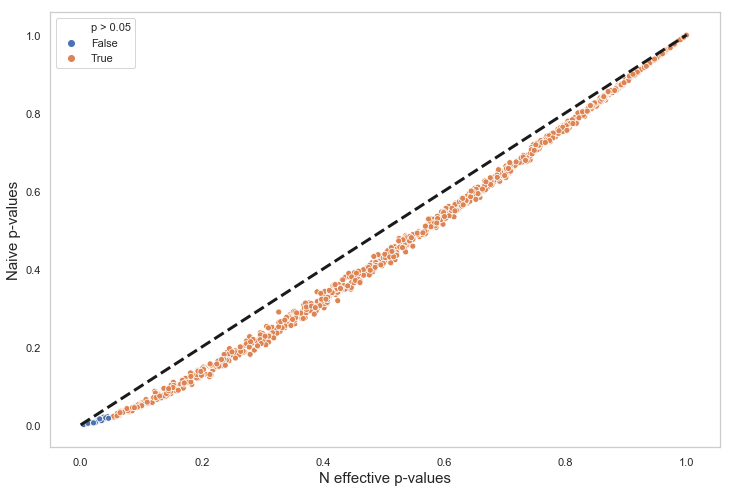

In [67]:
x = np.linspace(0, 1, 100)
plt.figure(figsize=((12, 8)))
plt.plot(x, x, 'k--', linewidth=3)
sns.scatterplot(x="p-value", y="Naive pvalue", hue="p > 0.05", data=summary)
plt.xlabel('N effective p-values', fontsize=15)
plt.ylabel('Naive p-values', fontsize=15);

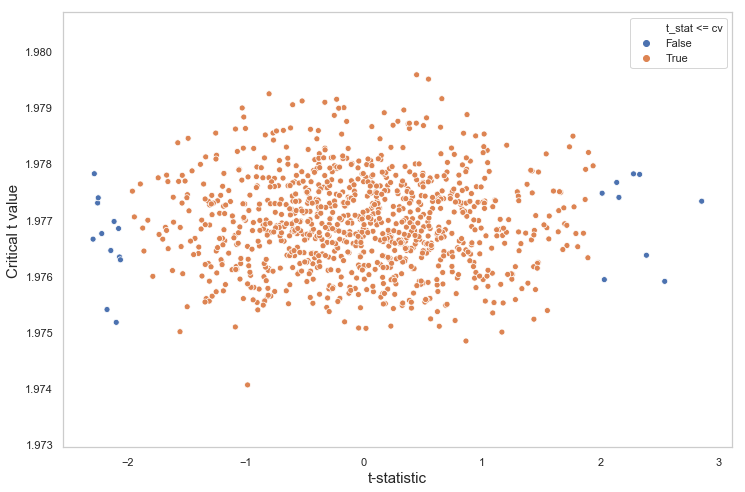

In [68]:
plt.figure(figsize=((12, 8)))
sns.scatterplot(x="t_stat", y="Critical Value", hue="t_stat <= cv", data=summary)
plt.xlabel('t-statistic', fontsize=15)
plt.ylabel('Critical t value', fontsize=15);

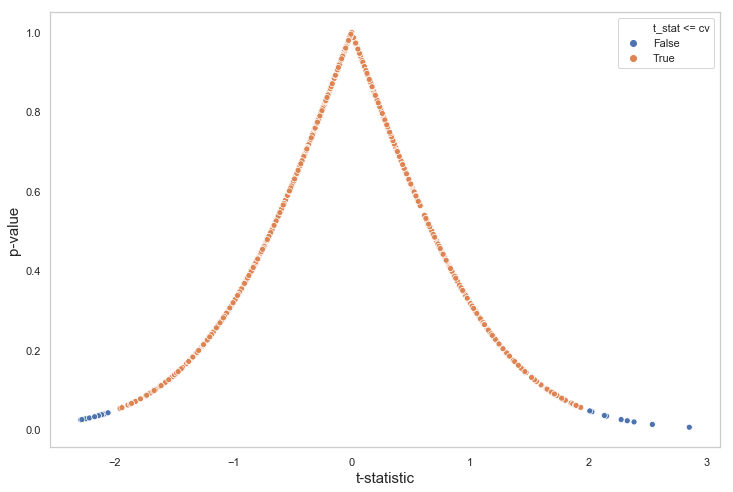

In [69]:
plt.figure(figsize=((12, 8)))
sns.scatterplot(x="t_stat", y="p-value", hue="t_stat <= cv", data=summary)
plt.xlabel('t-statistic', fontsize=15)
plt.ylabel('p-value', fontsize=15);

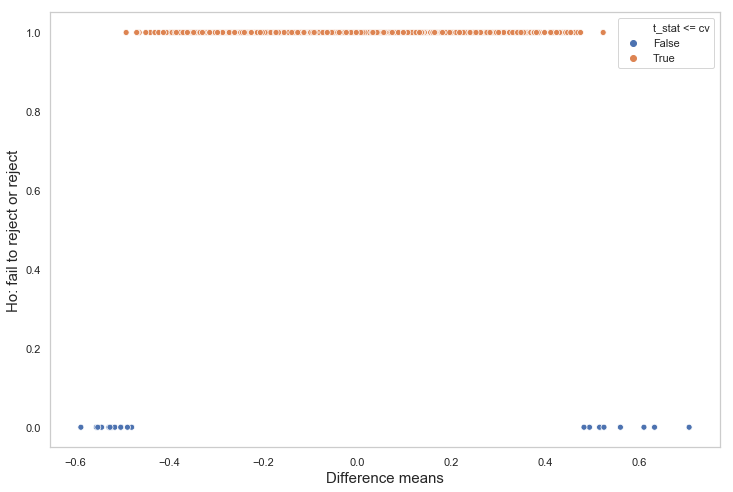

In [70]:
plt.figure(figsize=((12, 8)))
sns.scatterplot(x="Diff Means", y="p > 0.05", hue="t_stat <= cv", data=summary)
plt.xlabel('Difference means', fontsize=15)
plt.ylabel('Ho: fail to reject or reject', fontsize=15);

In [49]:
len(summary) - sum(summary['t_stat <= cv']) # n effective

592

In [53]:
# Using the p-value with a significance level of 5%
len(summary[summary['p > 0.05'] == False])

230

Bingo! 5% of all the simulations have rejected $H_0$.

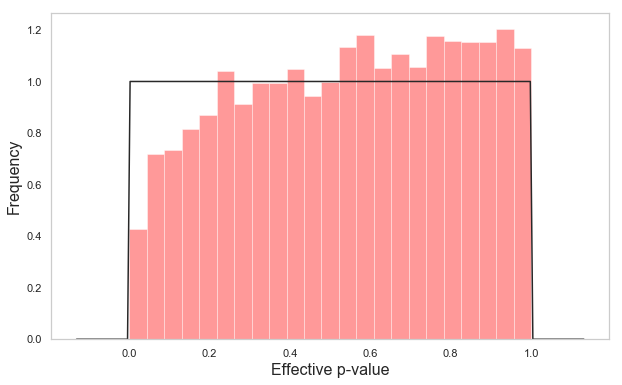

In [50]:
plt.figure(figsize=(10, 6))
sns.distplot(summary['p-value'], kde=False, fit=stats.uniform, color='red')
plt.xlabel('Effective p-value',fontsize='16')
plt.ylabel('Frequency',fontsize='16');

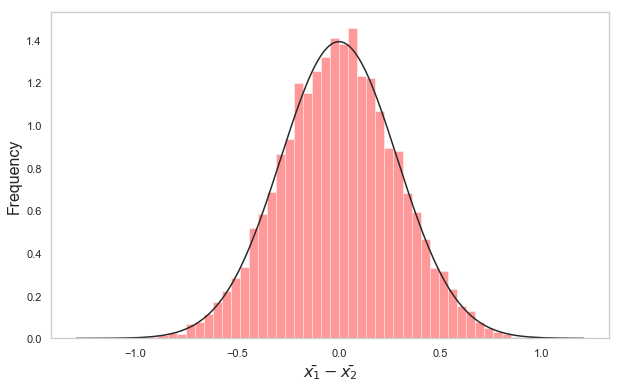

In [52]:
plt.figure(figsize=(10, 6))
sns.distplot(summary['Diff Means'], kde=False, fit=stats.t, color='red')
plt.xlabel(r'$\bar{x_1} - \bar{x_2}$',fontsize='16')
plt.ylabel('Frequency',fontsize='16');

In [48]:
summary.to_pickle("./summary3.pkl")

## Random sampling is performed within a fixed area smaller than field

In [161]:
x = np.arange(200, 400, 10) # The field has 100 cells in both X and Y and extends from 0 to 990 meters
xx, yy = np.meshgrid(x, x) # create a meshgrid to simplify the addition of coordinate 

# X coordinates format
xcoor = list(x)
xcoor = np.array(xcoor * 20)

# Y coordinates format
ycoor = []
for i in np.arange(len(x)):
    ycoor += list(yy[i, :])
ycoor = np.array(ycoor)
    
# DataFrame
simulation = pd.DataFrame(np.ndarray.flatten(sim[20:40, 20:40]), columns=['Porosity'])
simulation['X'] = xcoor
simulation['Y'] = ycoor

In [172]:
N1 = simulation.sample(frac=0.125, random_state=1960) # random sampling of 100 values: 1% of 10,000
N2 = simulation.sample(frac=0.125, random_state=1963) # random sampling

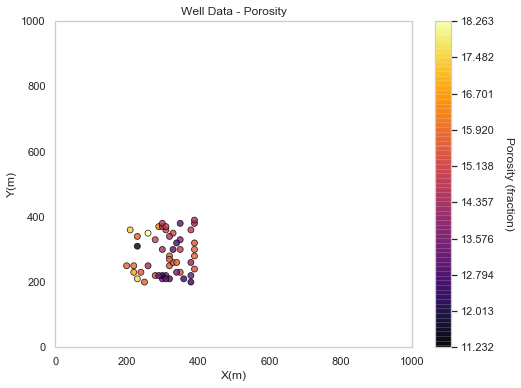

In [173]:
pormin = N1['Porosity'].min()
pormax = N2['Porosity'].max()

GSLIB.locmap(N1, 'X', 'Y', 'Porosity', xmin, xmax, ymin, ymax, pormin, pormax,
             'Well Data - Porosity', 'X(m)', 'Y(m)', 'Porosity (fraction)', cmap,'locmap_Porosity');

In [188]:
tic()

num_sim = 1000 # number of sim_is

# create the DataFrame that will store all results
summary = pd.DataFrame(np.zeros((num_sim, 11)), columns=['N1 Mean', 'N2 Mean', 'Diff Means','N1 neff', 
                                                        'N2 neff', 'N eff', 'Naive t', 'Naive pvalue',
                                                        't_stat', 'p-value', 'Critical Value'])

means_diff = np.zeros((num_sim, 1)) # initialize the array where you will store the difference of means
n_eff = np.zeros_like(means_diff) # initialize the array where you will store the average n effective

for sim_i in range(0, num_sim):
    sim = GSLIB.sgsim_uncond(1, nx, ny, cell_size, seed+sim_i, vario, 'sim_i')
    sim = GSLIB.affine(array=sim, tmean=15, tstdev=1.5) # correct the distribution to a target mean and standard deviation
    
    ############################################################
    ## Compute the means of the data sampling sets
    ############################################################
    mean1 = np.mean(sim.ravel()[N1.index.values])
    mean2 = np.mean(sim.ravel()[N2.index.values])
    summary.iloc[sim_i, 0] = mean1
    summary.iloc[sim_i, 1] = mean2
    
    ############################################################
    ## Compute n effective of both data sampling sets
    ############################################################
    n1 = n_effective(N1, 'X', 'Y', seed=seed+sim_i, nreal=1000, vario=vario)
    n2 = n_effective(N2, 'X', 'Y', seed=seed+sim_i, nreal=1000, vario=vario)
    summary.iloc[sim_i, 3] = n1
    summary.iloc[sim_i, 4] = n2
    
    ############################################################
    ## Welch's test using scipy
    ############################################################
    # two-tailed test
    summary.iloc[sim_i, 6], summary.iloc[sim_i, 7] \
    = welch(sim.ravel()[N1.index.values], sim.ravel()[N2.index.values], axis=None, equal_var=False)
    
    ############################################################
    ## Welch's test using n effective
    ############################################################
    # t statistic
    var1 = np.var(sim.ravel()[N1.index.values], ddof=1) # ddof=1 means that we are dividing by n-1 to have an unbiased statistic
    var2 = np.var(sim.ravel()[N2.index.values], ddof=1)
    t_stat = (mean1 - mean2) / np.sqrt((var1/n1) + (var2/n2))
    summary.iloc[sim_i, 8] = t_stat # saving the t statistic considering n effective
    
    # degrees of freedom
    if n1 <= 1:
        n1 = 2
        print('n1 has changed')
    elif n2 <= 2:
        n2 = 2
        print('n2 has changed')

    dof = (((var1 / n1) + (var2 / n2)) ** 2) \
            /((((var1 / n1)**2) / (n1 - 1)) + (((var2 / n2)**2) / (n2 - 1)))
    
    # calculate the critical value
    critical_value = stats.t.ppf(1.0 - 0.05/2, dof) # percent point function (PPF) for a 5% significance level
    summary.iloc[sim_i, 10] = critical_value # store the critical value in the DataFrame
    
    # calculate the p-value
    p = (1 - stats.t.cdf(abs(t_stat), dof)) * 2 # compute the two-tail p-value 
    summary.iloc[sim_i, 9] = p # store that p-value
    
############################################################
## Final computations
############################################################
summary['Diff Means'] = summary['N1 Mean'] - summary['N2 Mean'] # compute difference of the means
summary['N eff'] = (summary['N1 neff'] + summary['N2 neff']) / 2 # average of n effectives
summary['t_stat <= cv'] = abs(summary['t_stat']) <= summary['Critical Value'] # whether or not to reject Ho using t_stat
summary['p > 0.05'] = summary['p-value'] > 0.05 # whether or not to reject Ho using the p-value

toc()

Time elapsed:0 hours 4 minutes 24 seconds.


In [189]:
summary.head()

,N1 Mean,N2 Mean,Diff Means,N1 neff,N2 neff,N eff,Naive t,Naive pvalue,t_stat,p-value,Critical Value,t_stat <= cv,p > 0.05
0,14.561576,14.205101,0.356475,7.775615,8.065336,7.920475,1.537108,0.127521,0.612231,0.550346,1.763191,True,True
1,14.732886,15.140866,-0.407980,7.952707,8.711740,8.332224,-1.526637,0.130077,-0.623084,0.542833,1.756119,True,True
2,14.997161,15.335462,-0.338301,8.251766,9.217027,8.734397,-1.208247,0.229865,-0.504826,0.620836,1.750188,True,True
3,15.091652,14.776528,0.315125,8.423727,8.876768,8.650248,0.989627,0.324797,0.411675,0.686289,1.750838,True,True
4,15.166946,15.141988,0.024959,8.329740,8.600522,8.465131,0.075339,0.940100,0.030968,0.975714,1.756078,True,True


In [190]:
len(summary) - sum(summary['t_stat <= cv']) # n effective

0

In [191]:
# Using the p-value with a significance level of 5%
len(summary[summary['p > 0.05'] == False])

0

In [192]:
summary['Naive pvalue'][summary['Naive pvalue'] < 0.05].count() # naive Welch

63

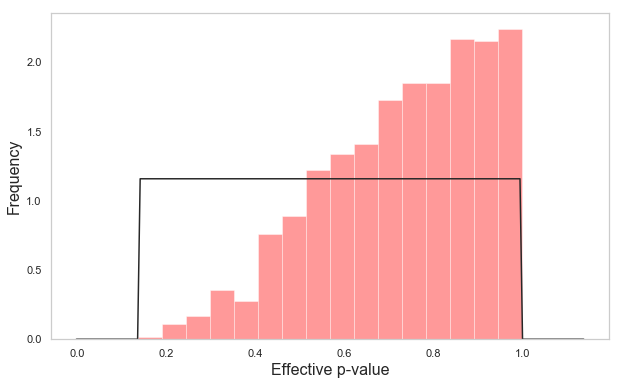

In [193]:
plt.figure(figsize=(10, 6))
sns.distplot(summary['p-value'], kde=False, fit=stats.uniform, color='red')
plt.xlabel('Effective p-value',fontsize='16')
plt.ylabel('Frequency',fontsize='16');

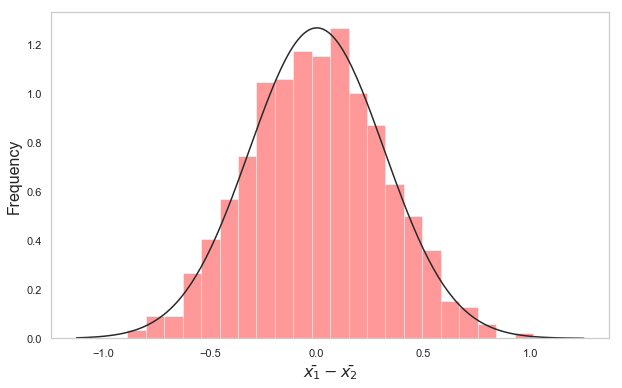

In [194]:
plt.figure(figsize=(10, 6))
sns.distplot(summary['Diff Means'], kde=False, fit=stats.t, color='red')
plt.xlabel(r'$\bar{x_1} - \bar{x_2}$',fontsize='16')
plt.ylabel('Frequency',fontsize='16');

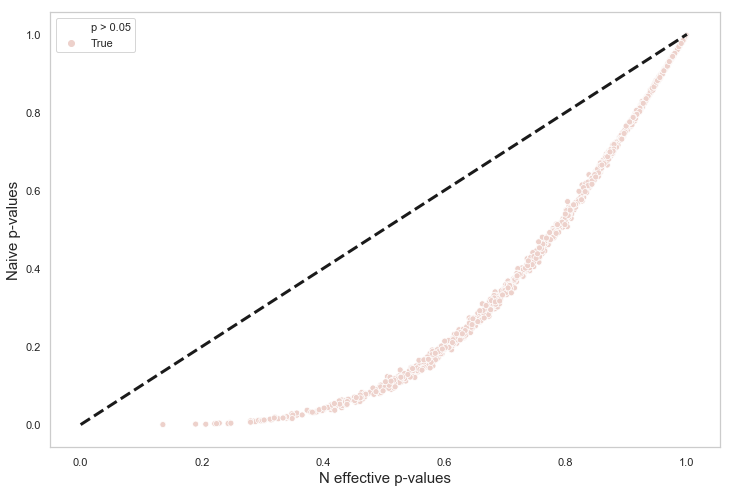

In [195]:
x = np.linspace(0, 1, 100)
plt.figure(figsize=((12, 8)))
plt.plot(x, x, 'k--', linewidth=3)
sns.scatterplot(x="p-value", y="Naive pvalue", hue="p > 0.05", data=summary)
plt.xlabel('N effective p-values', fontsize=15)
plt.ylabel('Naive p-values', fontsize=15);

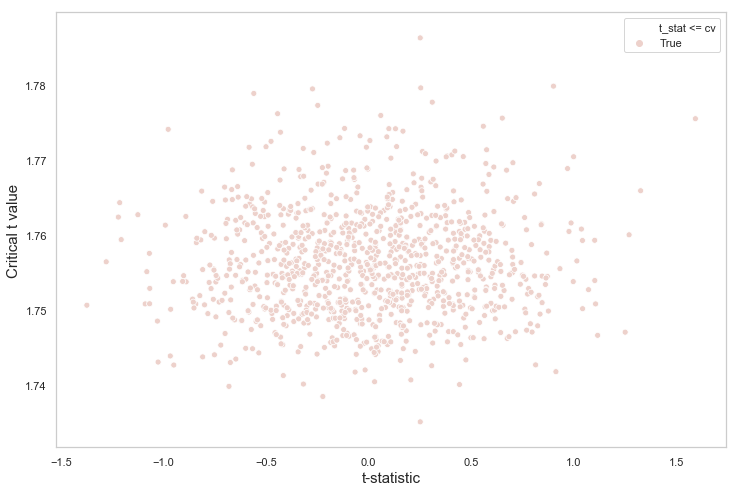

In [196]:
plt.figure(figsize=((12, 8)))
sns.scatterplot(x="t_stat", y="Critical Value", hue="t_stat <= cv", data=summary)
plt.xlabel('t-statistic', fontsize=15)
plt.ylabel('Critical t value', fontsize=15);

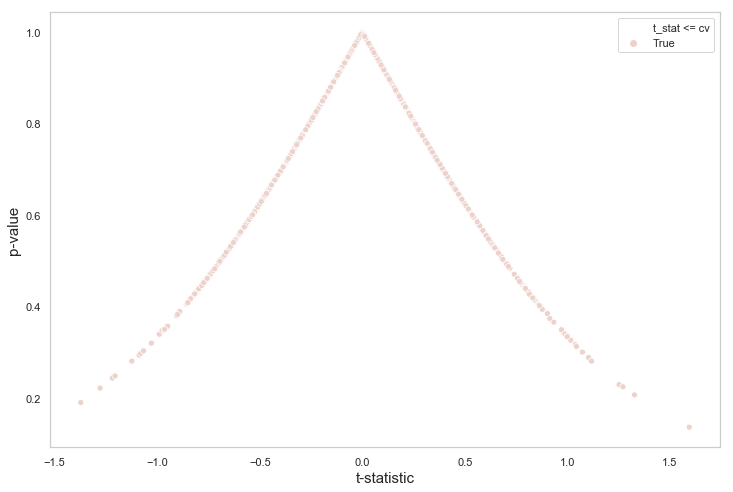

In [197]:
plt.figure(figsize=((12, 8)))
sns.scatterplot(x="t_stat", y="p-value", hue="t_stat <= cv", data=summary)
plt.xlabel('t-statistic', fontsize=15)
plt.ylabel('p-value', fontsize=15);

## Pure nugget effect

<Figure size 720x576 with 0 Axes>

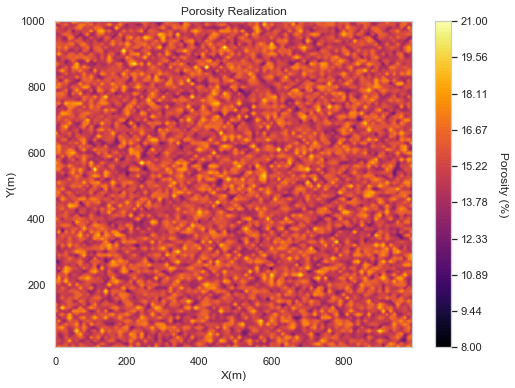

In [220]:
vario = GSLIB.make_variogram(nug=1, nst=1, it1=1, cc1=0.0, azi1=azimuth, hmaj1=90, hmin1=70) # pure nugget effect
sim = GSLIB.sgsim_uncond(1, nx, ny, cell_size, seed, vario, 'simulation')

sim = GSLIB.affine(sim, mean, stdev)              # correct the distribution to a target mean and standard deviation.

plt.figure(figsize=(10, 8));
                       
GSLIB.pixelplt(sim, xmin, xmax, ymin, ymax, cell_size, np.floor(np.min(sim)), np.ceil(np.max(sim)),
               "Porosity Realization", "X(m)", "Y(m)", "Porosity (%)",cmap, 'Porosity_Simulation');

In [127]:
x = np.arange(0, 999, 10) # The field has 100 cells in both X and Y and extends from 0 to 990 meters
xx, yy = np.meshgrid(x, x) # create a meshgrid to simplify the addition of coordinate 

# X coordinates format
xcoor = list(x)
xcoor = np.array(xcoor * 100)

# Y coordinates format
ycoor = []
for i in np.arange(len(x)):
    ycoor += list(yy[i, :])
ycoor = np.array(ycoor)
    
# DataFrame
simulation = pd.DataFrame(np.ndarray.flatten(sim), columns=['Porosity'])
simulation['X'] = xcoor
simulation['Y'] = ycoor

N1 = simulation.sample(frac=0.01, random_state=42) # random sampling of 100 values: 10% of 10,000
N2 = simulation.sample(frac=0.01, random_state=13) # random sampling

In [233]:
tic()

num_sim = 1000 # number of sim_is

# create the DataFrame that will store all results
summary = pd.DataFrame(np.zeros((num_sim, 11)), columns=['N1 Mean', 'N2 Mean', 'Diff Means','N1 neff', 
                                                        'N2 neff', 'N eff', 'Naive t', 'Naive pvalue',
                                                        't_stat', 'p-value', 'Critical Value'])

means_diff = np.zeros((num_sim, 1)) # initialize the array where you will store the difference of means
n_eff = np.zeros_like(means_diff) # initialize the array where you will store the average n effective

for sim_i in range(0, num_sim):
    sim = GSLIB.sgsim_uncond(1, nx, ny, cell_size, seed+sim_i, vario, 'sim_i')
    sim = GSLIB.affine(array=sim, tmean=15, tstdev=1.5) # correct the distribution to a target mean and standard deviation
    
    ############################################################
    ## Compute the means of the data sampling sets
    ############################################################
    mean1 = np.mean(sim.ravel()[N1.index.values])
    mean2 = np.mean(sim.ravel()[N2.index.values])
    summary.iloc[sim_i, 0] = mean1
    summary.iloc[sim_i, 1] = mean2
    
    ############################################################
    ## Compute n effective of both data sampling sets
    ############################################################
    n1 = n_effective(N1, 'X', 'Y', seed=seed+sim_i, nreal=1000, vario=vario)
    n2 = n_effective(N2, 'X', 'Y', seed=seed+sim_i, nreal=1000, vario=vario)
    summary.iloc[sim_i, 3] = n1
    summary.iloc[sim_i, 4] = n2
    
    ############################################################
    ## Welch's test using scipy
    ############################################################
    # two-tailed test
    summary.iloc[sim_i, 6], summary.iloc[sim_i, 7] \
    = welch(sim.ravel()[N1.index.values], sim.ravel()[N2.index.values], axis=None, equal_var=False)
    
    ############################################################
    ## Welch's test using n effective
    ############################################################
    # t statistic
    var1 = np.var(sim.ravel()[N1.index.values], ddof=1) # ddof=1 means that we are dividing by n-1 to have an unbiased statistic
    var2 = np.var(sim.ravel()[N2.index.values], ddof=1)
    t_stat = (mean1 - mean2) / np.sqrt((var1/n1) + (var2/n2))
    summary.iloc[sim_i, 8] = t_stat # saving the t statistic considering n effective
    
    # degrees of freedom
    if n1 <= 1:
        n1 = 2
        print('n1 has changed')
    elif n2 <= 2:
        n2 = 2
        print('n2 has changed')

    dof = (((var1 / n1) + (var2 / n2)) ** 2) \
            /((((var1 / n1)**2) / (n1 - 1)) + (((var2 / n2)**2) / (n2 - 1)))
    
    # calculate the critical value
    critical_value = stats.t.ppf(1.0 - 0.05/2, dof) # percent point function (PPF) for a 5% significance level
    summary.iloc[sim_i, 10] = critical_value # store the critical value in the DataFrame
    
    # calculate the p-value
    p = (1 - stats.t.cdf(abs(t_stat), dof)) * 2 # compute the two-tail p-value 
    summary.iloc[sim_i, 9] = p # store that p-value
    
############################################################
## Final computations
############################################################
summary['Diff Means'] = summary['N1 Mean'] - summary['N2 Mean'] # compute difference of the means
summary['N eff'] = (summary['N1 neff'] + summary['N2 neff']) / 2 # average of n effectives
summary['t_stat <= cv'] = abs(summary['t_stat']) <= summary['Critical Value'] # whether or not to reject Ho using t_stat
summary['p > 0.05'] = summary['p-value'] > 0.05 # whether or not to reject Ho using the p-value

toc()

Time elapsed:0 hours 4 minutes 45 seconds.


In [234]:
summary.head()

,N1 Mean,N2 Mean,Diff Means,N1 neff,N2 neff,N eff,Naive t,Naive pvalue,t_stat,p-value,Critical Value,t_stat <= cv,p > 0.05
0,14.859192,15.119835,-0.260643,91.992014,91.992014,91.992014,-1.232774,0.219126,-1.182384,0.238600,1.653294,True,True
1,14.980124,15.185267,-0.205143,100.000000,100.000000,100.000000,-1.011958,0.312793,-1.011958,0.312793,1.652586,True,True
2,14.806174,14.844543,-0.038369,100.000000,100.000000,100.000000,-0.175843,0.860599,-0.175843,0.860599,1.652663,True,True
3,14.949403,15.129382,-0.179979,99.457027,99.457027,99.457027,-0.843326,0.400097,-0.841033,0.401383,1.652881,True,True
4,14.796781,15.075096,-0.278314,100.000000,100.000000,100.000000,-1.431848,0.153781,-1.431848,0.153781,1.652669,True,True


In [235]:
len(summary) - sum(summary['t_stat <= cv']) # n effective

86

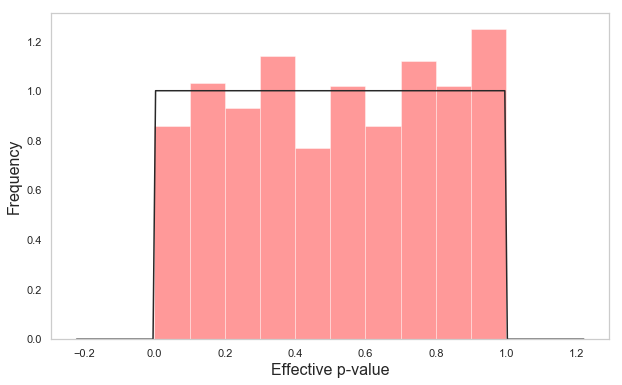

In [236]:
plt.figure(figsize=(10, 6))
sns.distplot(summary['p-value'], kde=False, fit=stats.uniform, color='red')
plt.xlabel('Effective p-value',fontsize='16')
plt.ylabel('Frequency',fontsize='16');

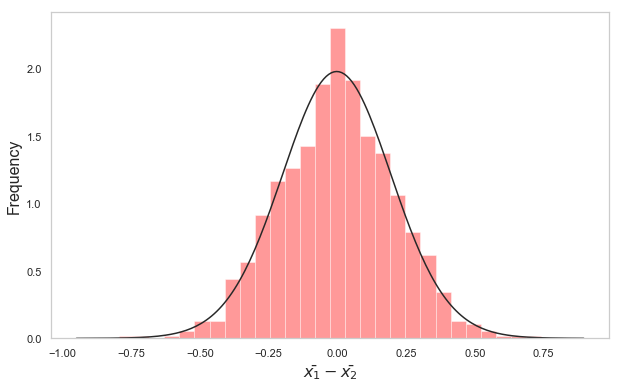

In [237]:
plt.figure(figsize=(10, 6))
sns.distplot(summary['Diff Means'], kde=False, fit=stats.t, color='red')
plt.xlabel(r'$\bar{x_1} - \bar{x_2}$',fontsize='16')
plt.ylabel('Frequency',fontsize='16');

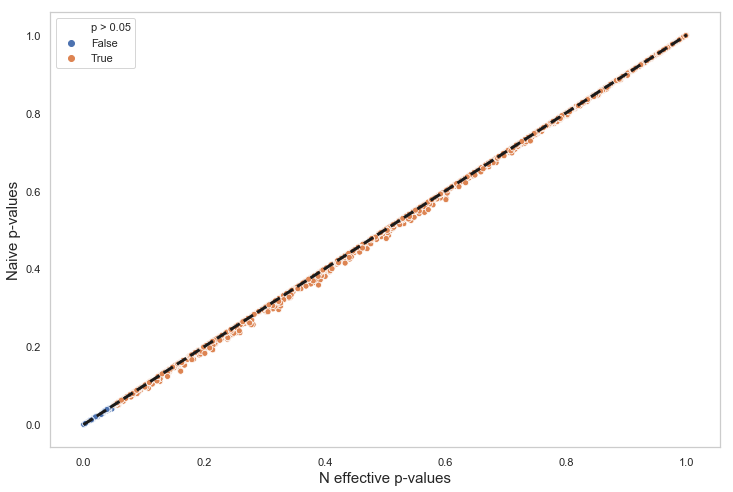

In [238]:
x = np.linspace(0, 1, 100)
plt.figure(figsize=((12, 8)))
plt.plot(x, x, 'k--', linewidth=3)
sns.scatterplot(x="p-value", y="Naive pvalue", hue="p > 0.05", data=summary)
plt.xlabel('N effective p-values', fontsize=15)
plt.ylabel('Naive p-values', fontsize=15);

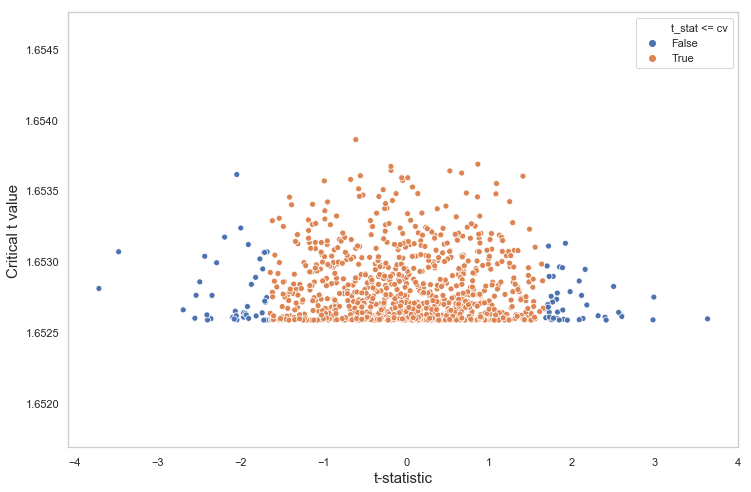

In [239]:
plt.figure(figsize=((12, 8)))
sns.scatterplot(x="t_stat", y="Critical Value", hue="t_stat <= cv", data=summary)
plt.xlabel('t-statistic', fontsize=15)
plt.ylabel('Critical t value', fontsize=15);

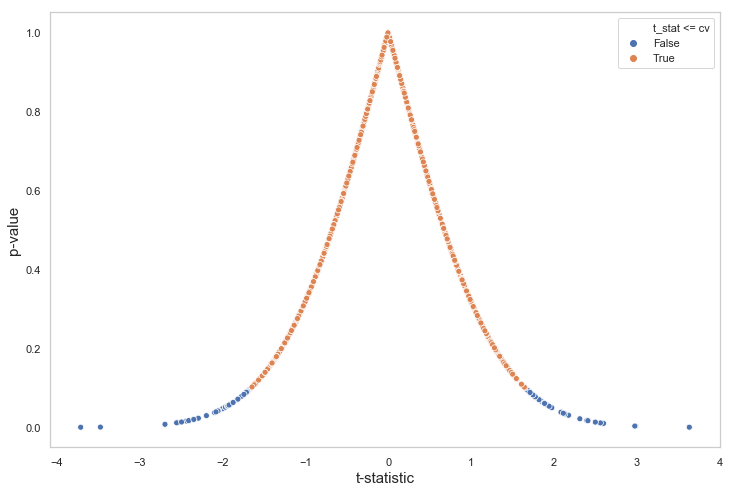

In [240]:
plt.figure(figsize=((12, 8)))
sns.scatterplot(x="t_stat", y="p-value", hue="t_stat <= cv", data=summary)
plt.xlabel('t-statistic', fontsize=15)
plt.ylabel('p-value', fontsize=15);

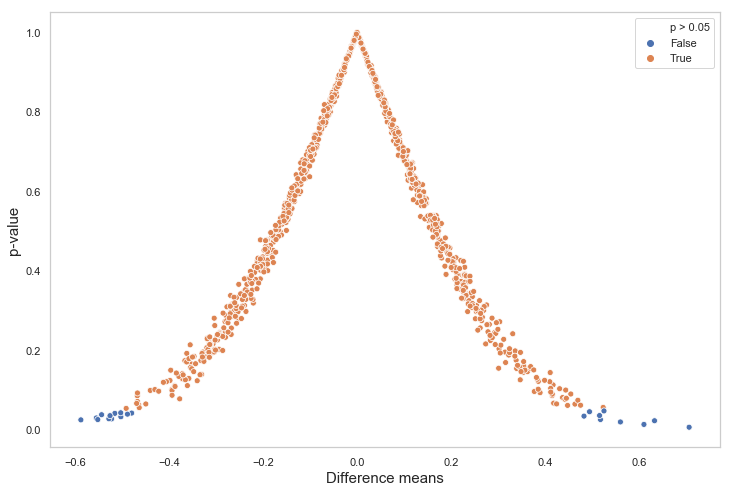

In [71]:
plt.figure(figsize=((12, 8)))
sns.scatterplot(x="Diff Means", y="p-value", hue="p > 0.05", data=summary)
plt.xlabel('Difference means', fontsize=15)
plt.ylabel('p-value', fontsize=15);